#  Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from foraging import plotting
from foraging import utils

pd.options.mode.copy_on_write = True

import plotting.beliefs
import plotting.behavior
import utils.beliefs
import utils.data
import utils.models
from plotting import BOX_LABELS, BOX_COLORS
from plotting import bp

# constants
SEED = 42
RNG = np.random.default_rng(SEED)
DATA_DIR = '../data'

# Load data

The experiment data consists of multiple matfiles corresponding to the data for different subjects. Each matfile contains that subject's push, eye tracking (if available), and position (if available) data organized by blocks and sessions. Each block corresponds to a set of experiment parameters, notably the schedule of each box, the stimulus reliability kappa, and the stimulus type. A hierarchical overview of a given matfile is given in the `Angelaki Data Cleaning` notebook.

In [2]:
df = utils.data.make_dataframe(os.path.join(DATA_DIR, 'experiments'))
df = utils.data.exclusion_criteria(df)
df = utils.data.filter_df(df, {'kappa': 0})
display(Markdown(df.head()[["box", "push times", "reward outcomes"]].to_markdown()))

|                                                   |   box |   push times | reward outcomes   |
|:--------------------------------------------------|------:|-------------:|:------------------|
| ('humans', 1, 3, 1, 'availability', 10, 0.0, nan) |     2 |       6.438  | False             |
| ('humans', 1, 3, 2, 'availability', 10, 0.0, nan) |     3 |      12.0799 | True              |
| ('humans', 1, 3, 3, 'availability', 10, 0.0, nan) |     1 |      15.8225 | False             |
| ('humans', 1, 3, 4, 'availability', 10, 0.0, nan) |     3 |      20.0872 | True              |
| ('humans', 1, 3, 5, 'availability', 10, 0.0, nan) |     2 |      24.0079 | True              |

## Data Overview
A quick overview of the summary statistics

In [3]:
print("schedules experienced by each subject")
print(df.groupby('subject')['schedule'].unique())

schedules experienced by each subject
subject
humans    [14.0, 7.0, 21.0]
viktor    [21.0, 14.0, 7.0]
Name: schedule, dtype: object


<Axes: xlabel='subject', ylabel='n pushes per block'>

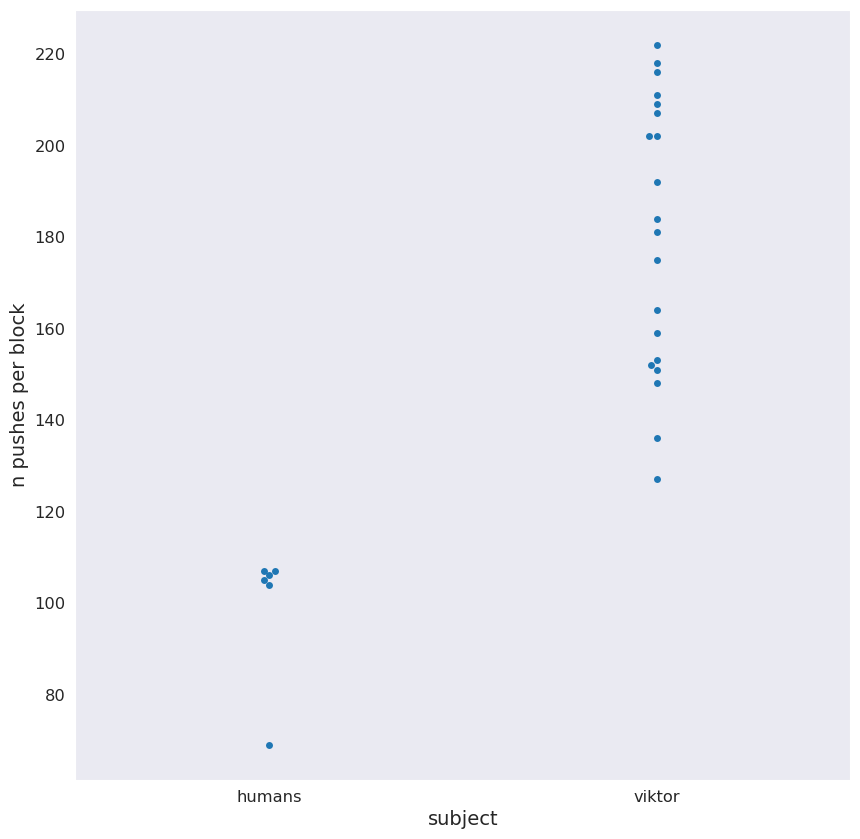

In [4]:
n_pushes_per_block = df.groupby(['subject', 'session', 'block']).size().reset_index(name='n pushes per block')
fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(n_pushes_per_block, x='subject', y='n pushes per block', ax=ax)

Now load pre-existing data structures generated in `Bulk Data Processing`.

In [5]:
ds = utils.data.load_pickled_data(os.path.join(DATA_DIR, 'analysis/bulk_beliefs.pkl'))
data, error, schedule_candidates, dt, pt = ds.values()
posteriors, latent_beliefs_over_time, joint_beliefs, reward_beliefs, reward_probabilities = list(data.values())
error_all = set().union(*error.values())

# Align dataframe and belief data by dropping problematic blocks
if len(error_all) > 0:
    df = df.drop(error_all)

 # Schedule beliefs

Get the mean and standard deviation of the posteriors of the mean schedules for each block.

In [6]:
def mean(df: pd.DataFrame, index: tuple, exclude_prior: bool = True):
    res = utils.beliefs.get_mean_beliefs(posteriors[index].probabilities(record='all'), posteriors[index].support())
    if exclude_prior:
        return [x[1:] for x in res]
    return res

def std(df: pd.DataFrame, index: tuple, exclude_prior: bool = True):
    res = utils.beliefs.get_std_beliefs(posteriors[index].probabilities(record='all'), posteriors[index].support())
    if exclude_prior:
        return [x[1:] for x in res]
    return res

mean_schedule, err_mean = utils.data.process_blocks(df, mean)
uncertainty_schedule, err_uncertainty = utils.data.process_blocks(df, std)
utils.data.extend_df(df, mean_schedule, 'mean schedule', by_box=True)
utils.data.extend_df(df, uncertainty_schedule, 'uncertainty schedule', by_box=True);

Here are the beliefs from an example block. Feel free to change the `index` values to change the block to display. You can also change `x_col` parameter to `push times` or even `push # by box` which shows the beliefs as a function of experience at each box.

<Axes: title={'center': "Beliefs about schedule for ('viktor', 29, 3)\nkappa = 0.0, stim type = availability, shape = 10"}, xlabel='push times', ylabel='mean schedule'>

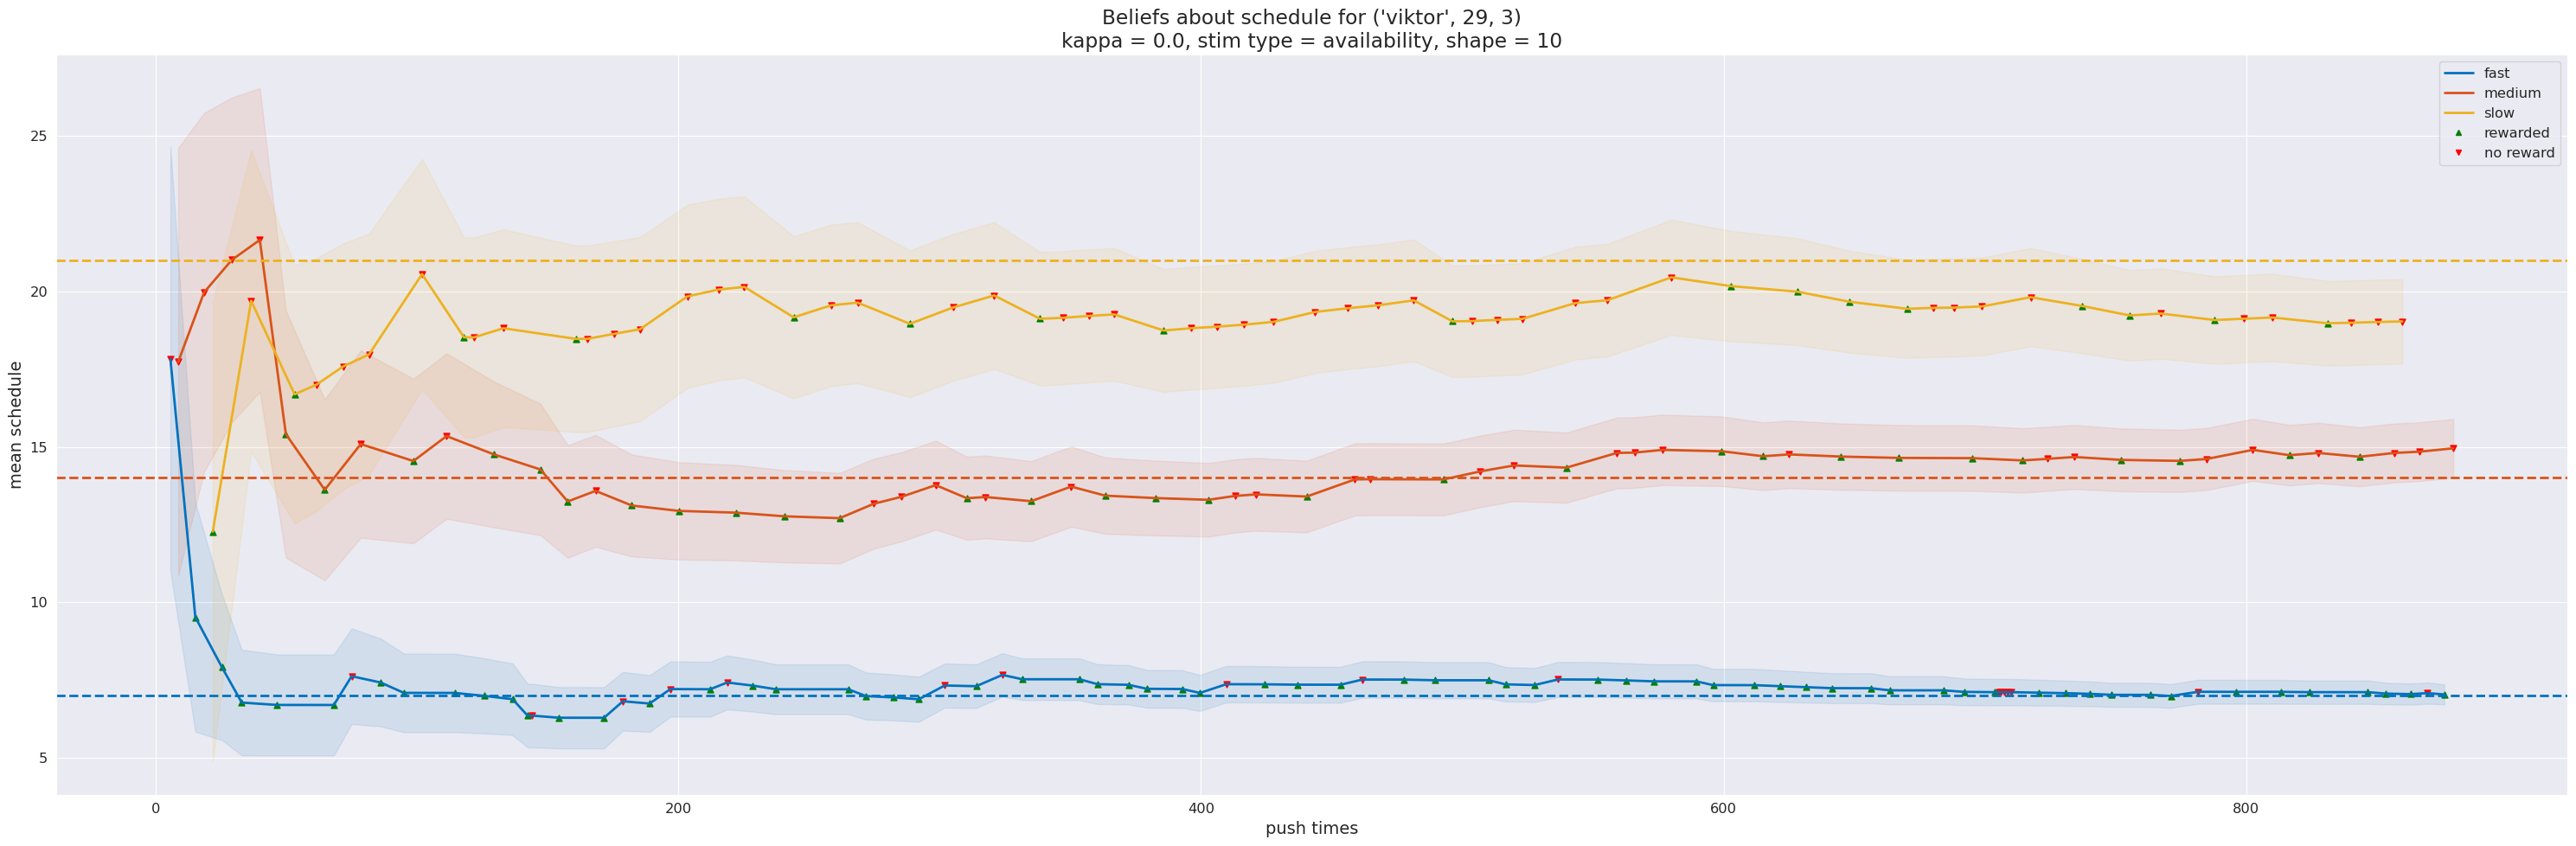

In [15]:
%matplotlib inline
index = 'viktor', 29, 3
plotting.beliefs.schedule_beliefs_block(df, index, x = 'push times', fig_kwargs={'figsize': (30,10)})

<Axes: xlabel='push #', ylabel='Boxes'>

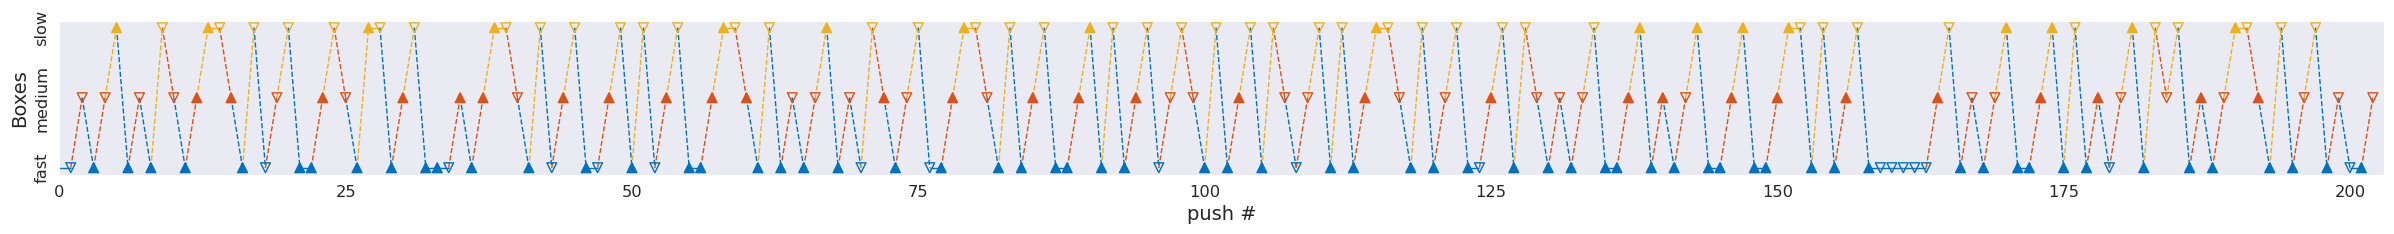

In [8]:
plotting.behavior.plot_block_events(df, index, fig_kwargs={'figsize': (30,2)}, legend = False)

Aggregating across blocks, these are the means and uncertainties for Viktor, aligned by experience at each box.

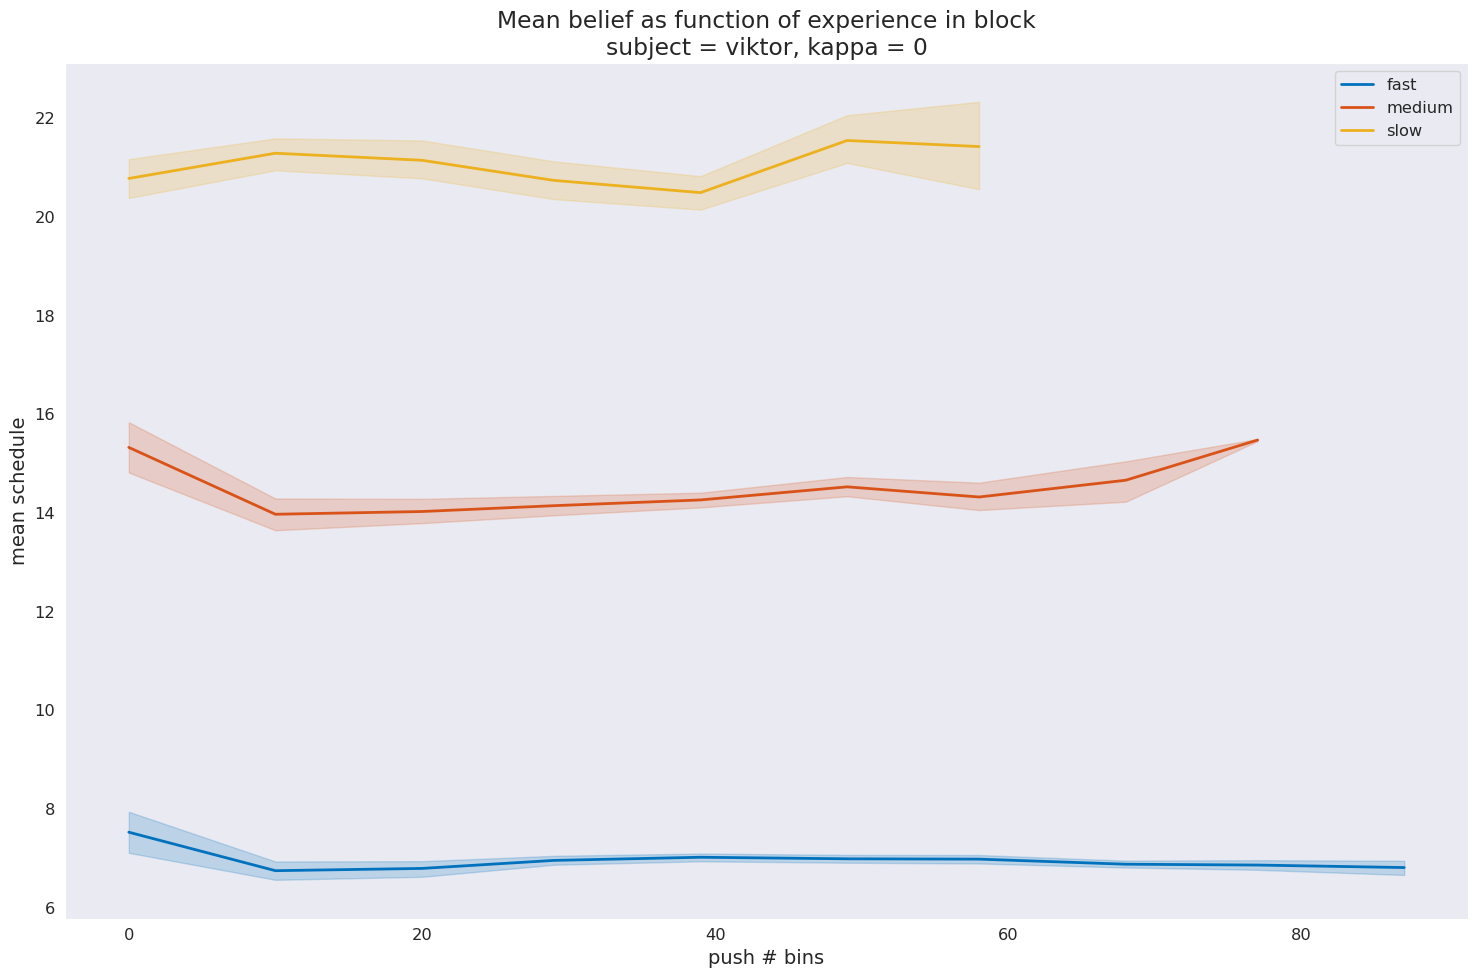

In [7]:
conds = {'subject': 'viktor', 'kappa': 0}
df_monkey = utils.data.filter_df(df, conds=conds)

# Binning data with pd.cut
df_monkey['push # bins'] = utils.data.bin_data(df_monkey, 'push # by box', 10, 'push # bins')
ax = bp(sns.lineplot)(df_monkey, conds=conds, x='push # bins', y='mean schedule', collapse=True,
                 title_prefix="Mean belief as function of experience in block")

In [16]:
df_monkey.groupby(['box rank', 'push # bins']).size()

/tmp/ipykernel_811465/2976822195.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_monkey.groupby(['box rank', 'push # bins']).size()


box rank  push # bins
0         0              199
          10             200
          20             179
          29             200
          39             199
          49             162
          58             151
          68              93
          77              69
          87              35
1         0              200
          10             192
          20             171
          29             186
          39             179
          49             126
          58              50
          68              15
          77               2
          87               0
2         0              200
          10             199
          20             171
          29             180
          39             147
          49              78
          58              26
          68               0
          77               0
          87               0
dtype: int64

<Axes: title={'center': 'Uncertainty as function of experience in block\nsubject = viktor, kappa = 0'}, xlabel='push # bins', ylabel='uncertainty schedule'>

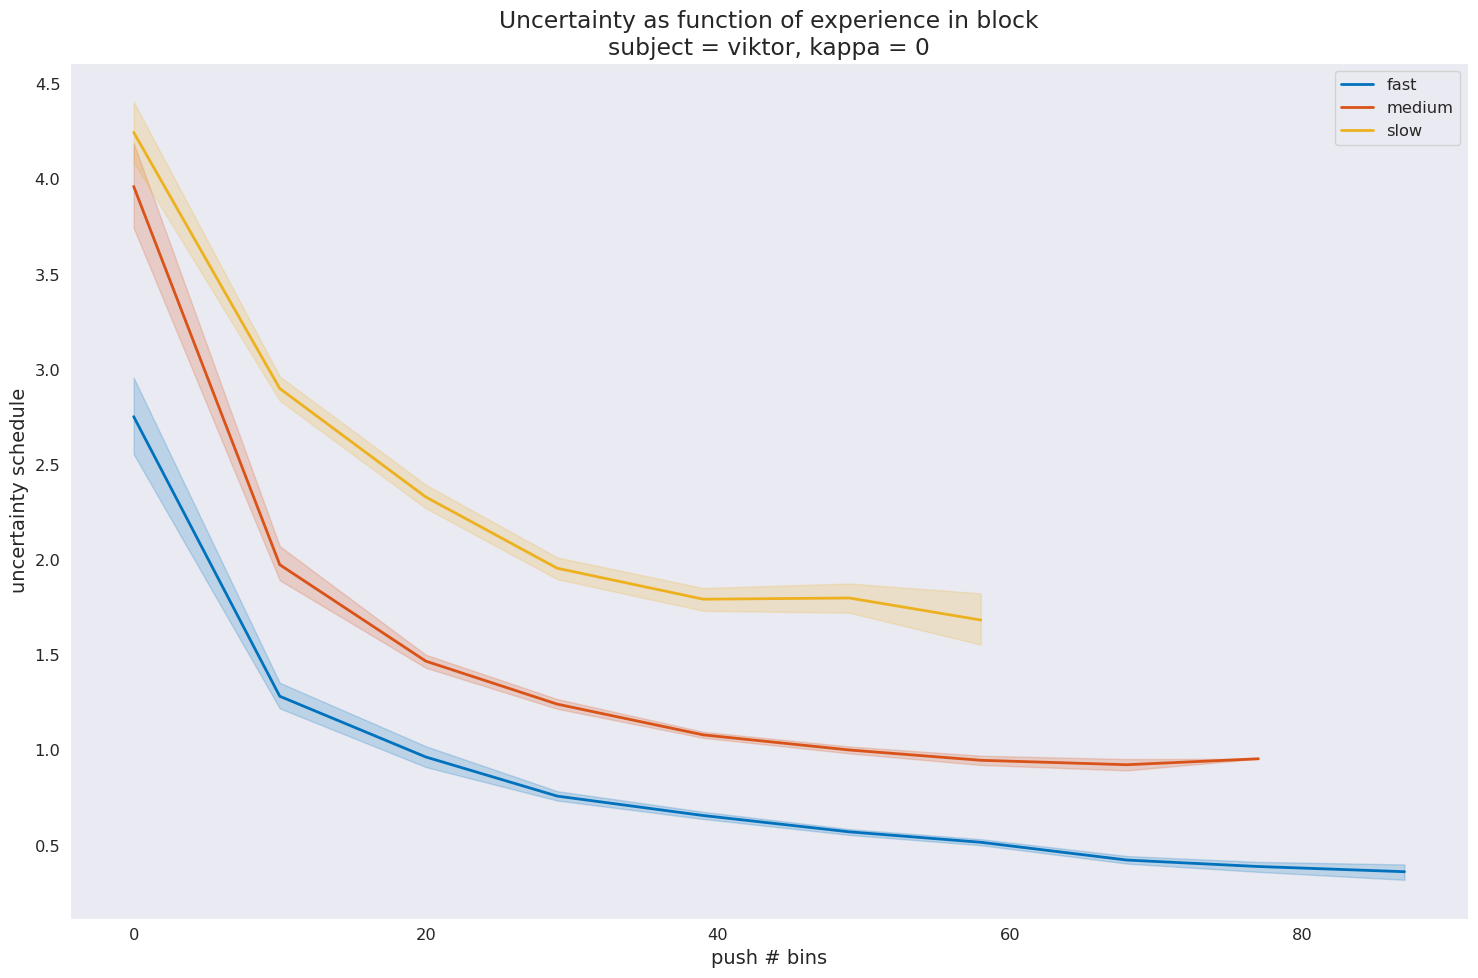

In [12]:
bp(sns.lineplot)(df_monkey, conds=conds, x='push # bins', y='uncertainty schedule', collapse=True,
                 title_prefix="Uncertainty as function of experience in block")

## Likelihood

In [8]:
%matplotlib notebook
pts = np.linspace(0.2, 40)
LL = np.zeros((len(schedule_candidates) * len(pts), 3))
shape = 10
obs_model = utils.models.GammaObservation(shape)
c = np.zeros(LL.shape[0])
cnt = 0
for i, latent in enumerate(schedule_candidates):
    for j, pt in enumerate(pts):
        LL[cnt] = (latent, pt, obs_model.probability((1, pt), latent))
        c[cnt] = pt
        cnt += 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(LL[:, 0], LL[:, 1], LL[:, 2], c=c)
ax.set_xlabel("schedule")
ax.set_ylabel("push interval")
ax.set_title("Likelihood of possible schedules \nafter observing reward")
# df_monkey['same-box push intervals'].min(), df_monkey['schedule'].max()

<IPython.core.display.Javascript object>

Text(0.5, 0.92, 'Likelihood of possible schedules \nafter observing reward')

# Reward beliefs

In [9]:
def rew_belief(df: pd.DataFrame, index: tuple, box):
    res = reward_beliefs[index][:,box,1].squeeze()
    return res

def rew_prob(df: pd.DataFrame, index: tuple, box):
    res = reward_probabilities[index][:,box].squeeze()
    return res

rew_beliefs_blocks = [utils.data.process_blocks(df_monkey, rew_belief, box) for box in range(3)]
rew_probs_blocks = [utils.data.process_blocks(df_monkey, rew_prob, box) for box in range(3)]
[utils.data.extend_df(df_monkey, rew_beliefs_blocks[box][0], f'reward beliefs box={box}', by_box=False) for box in range(3)]
[utils.data.extend_df(df_monkey, rew_probs_blocks[box][0], f'reward probs box={box}', by_box=False) for box in range(3)];

In [11]:
%matplotlib notebook
subject = 'viktor'
plotting.beliefs.reward_beliefs3d(df_monkey, df_monkey[[f'reward beliefs box={x}' for x in range(3)]].values, title=f"Belief about reward availability \nat time of push for {subject}")

<IPython.core.display.Javascript object>

<Axes3D: title={'center': 'Belief about reward availability \nat time of push for viktor'}, xlabel='Belief that reward is available at fast box', ylabel='Belief that reward is available at medium box', zlabel='Belief that reward is available at slow box'>

In [44]:
plotting.beliefs.reward_beliefs3d(df_monkey, df_monkey[[f'reward probs box={x}' for x in range(3)]].values, title=f"Exact reward probability \nat time of push for {subject}")

<IPython.core.display.Javascript object>

<Axes3D: title={'center': 'Exact reward probability \nat time of push for viktor'}, xlabel='Belief that reward is available at fast box', ylabel='Belief that reward is available at medium box', zlabel='Belief that reward is available at slow box'>

In [23]:
# marginal beliefs
marginal_score, marginal_mdl = utils.beliefs.predict_pushed_box(df_monkey, [f'reward beliefs box={x}' for x in range(3)])

# perfect beliefs
perfect_score, perfect_mdl = utils.beliefs.predict_pushed_box(df_monkey, [f'reward probs box={x}' for x in range(3)])
print(f"marginal belief score: {marginal_score}\nperfect model score: {perfect_score}")
marginal_mdl.summary(), perfect_mdl.summary()

marginal belief score: 0.6040454419506789
perfect model score: 0.6070933776669437


(<class 'statsmodels.iolib.summary.Summary'>
 """
                           MNLogit Regression Results                          
 Dep. Variable:                      y   No. Observations:                 3609
 Model:                        MNLogit   Df Residuals:                     3601
 Method:                           MLE   Df Model:                            6
 Date:                Tue, 11 Mar 2025   Pseudo R-squ.:                  0.1832
 Time:                        23:30:17   Log-Likelihood:                -3196.2
 converged:                       True   LL-Null:                       -3912.9
 Covariance Type:            nonrobust   LLR p-value:                1.441e-306
        y=1       coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 Intercept      1.0586      0.119      8.888      0.000       0.825       1.292
 X[0]          -2.8333      0.134    -21.101      0.000      -3.096   

In [24]:
belief_models = df_monkey.groupby('push # bins').apply(utils.beliefs.predict_pushed_box, [f'reward beliefs box={x}' for x in range(3)])

# Accessing results for each group
beliefs_results = []
for group, result in belief_models.items():
    print(f"\nGroup: {group}")
    print("score", result[0])
    if result[1]:
        print(result[1].summary())
        beliefs_results.append(result[0])
    else:
        print("N/A")


Group: 0
score 0.5809682804674458
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  599
Model:                        MNLogit   Df Residuals:                      591
Method:                           MLE   Df Model:                            6
Date:                Tue, 11 Mar 2025   Pseudo R-squ.:                  0.2013
Time:                        23:47:16   Log-Likelihood:                -525.60
converged:                       True   LL-Null:                       -658.07
Covariance Type:            nonrobust   LLR p-value:                 2.639e-54
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5341      0.314      4.893      0.000       0.920       2.149
X[0]          -3.1400      0.360     -8.726      0.000      -3.845      -2.435
X[1]           1.

/tmp/ipykernel_767331/3266781107.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  belief_models = df_monkey.groupby('push # bins').apply(utils.beliefs.predict_pushed_box, [f'reward beliefs box={x}' for x in range(3)])
/home/nquazi/miniconda3/envs/xaqlab/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/home/nquazi/miniconda3/envs/xaqlab/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]
/tmp/ipykernel_767331/3266781107.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the gr

In [33]:
exact_models = df_monkey.groupby('push # bins').apply(utils.beliefs.predict_pushed_box, [f'reward probs box={x}' for x in range(3)])

exact_results = []
# Accessing results for each group
for group, result in exact_models.items():
    print(f"\nGroup: {group}")
    print("score", result[0])
    if result[1]:
        print(result[1].summary())
        exact_results.append(result[0])
    else:
        print("N/A")


Group: 0
score 0.5809682804674458
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  599
Model:                        MNLogit   Df Residuals:                      591
Method:                           MLE   Df Model:                            6
Date:                Tue, 11 Mar 2025   Pseudo R-squ.:                  0.2065
Time:                        23:51:26   Log-Likelihood:                -522.16
converged:                       True   LL-Null:                       -658.07
Covariance Type:            nonrobust   LLR p-value:                 8.902e-56
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4674      0.315      4.663      0.000       0.851       2.084
X[0]          -3.1467      0.361     -8.709      0.000      -3.855      -2.438
X[1]           1.

/tmp/ipykernel_767331/1632645977.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exact_models = df_monkey.groupby('push # bins').apply(utils.beliefs.predict_pushed_box, [f'reward probs box={x}' for x in range(3)])
/tmp/ipykernel_767331/1632645977.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exact_models = df_monkey.groupby('push # bins').apply(utils.beliefs.predict_pushed_box, [f'reward probs box={x}' for x in range(3)])


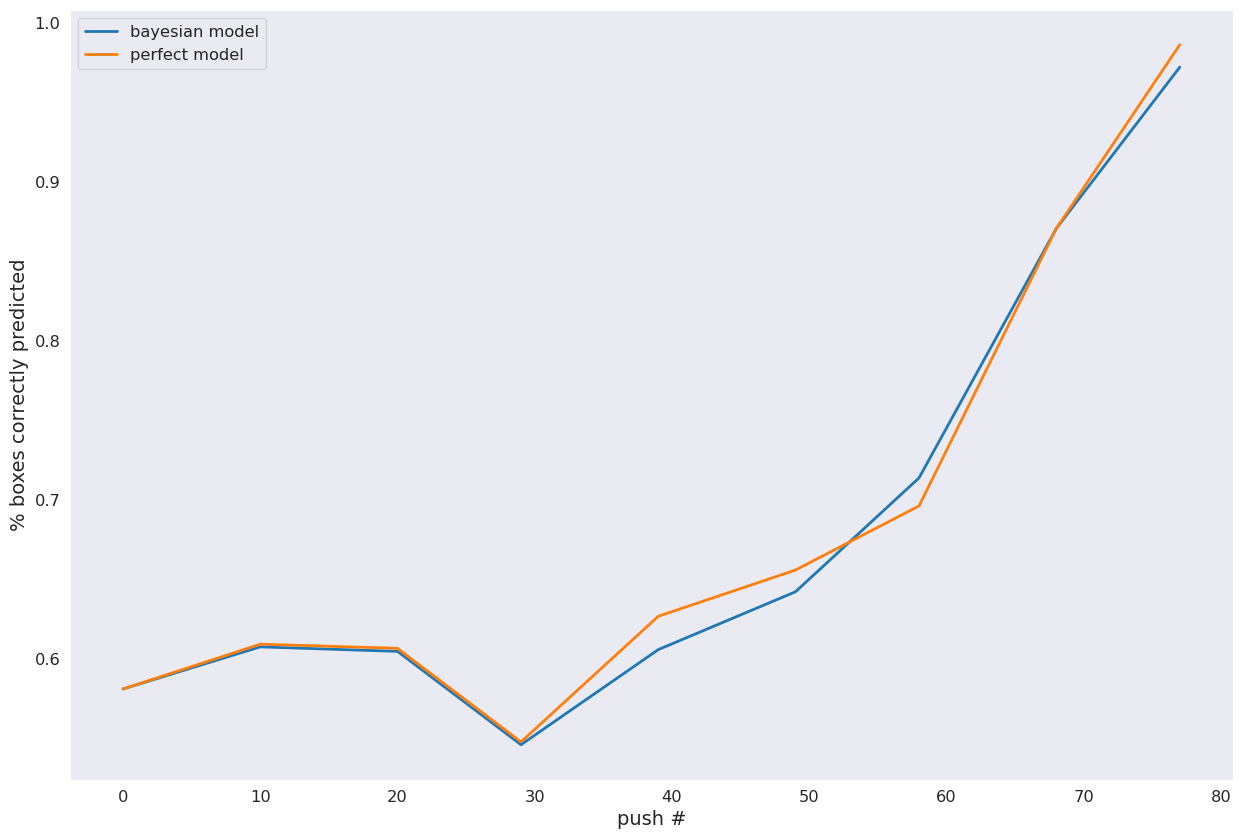

In [34]:
%matplotlib inline
fig = plt.figure()
plt.plot(df_monkey['push # bins'].unique()[:-1],beliefs_results, label = 'bayesian model')
plt.plot(df_monkey['push # bins'].unique()[:-1],exact_results, label = 'perfect model')
plt.xlabel("push #")
plt.ylabel("% boxes correctly predicted")
plt.legend()

## Likelihood under probabilistic policy with negligible action costs

In [35]:
def exclude_column_indices(n_cols: int, exclude_indices: np.ndarray) -> np.ndarray:
    """
    Generate a matrix where each row contains all column indices except for the one given in exclude_indices.

    Args:
        n_cols (int): Total number of columns.
        exclude_indices (np.ndarray): Array of column indices to exclude per row.

    Returns:
        np.ndarray: Matrix where each row contains all column indices except the excluded one.
    """
    all_indices = np.arange(n_cols)  # Create an array of all column indices
    return np.array([np.delete(all_indices, i) for i in exclude_indices])

def belief_likelihood_push(df: pd.DataFrame, index: tuple):
    df_block = df.loc[index]
    data = reward_beliefs[index]
    picked_probs = data[np.arange(data.shape[0])[:, None], df_block['box rank'].values[:,None], 1].squeeze()
    not_picked_index =exclude_column_indices(3, df_block['box rank'].values)
    not_picked_probs = data[np.arange(data.shape[0])[:, None], not_picked_index, 1].squeeze()
    # print(picked_probs.shape, not_picked_probs.shape, df_block['box rank'].values.shape, not_picked_index.shape)
    return picked_probs * (1 - not_picked_probs[:, 0]) * (1 - not_picked_probs[:, 1])

def rew_prob_likelihood_push(df: pd.DataFrame, index: tuple):
    df_block = df.loc[index]
    data = reward_probabilities[index]
    picked_probs = data[np.arange(data.shape[0])[:, None], df_block['box rank'].values[:,None]].squeeze()
    not_picked_index =exclude_column_indices(3, df_block['box rank'].values)
    not_picked_probs = data[np.arange(data.shape[0])[:, None], not_picked_index].squeeze()
    return picked_probs * (1 - not_picked_probs[:, 0]) * (1 - not_picked_probs[:, 1])

rew_beliefs_blocks, _ = utils.data.process_blocks(df_monkey, belief_likelihood_push)
rew_probs_blocks, _ = utils.data.process_blocks(df_monkey, rew_prob_likelihood_push)
utils.data.extend_df(df_monkey, rew_beliefs_blocks, f'likelihood beliefs', by_box=False)
utils.data.extend_df(df_monkey, rew_probs_blocks, f'likelihood reward probs', by_box=False);

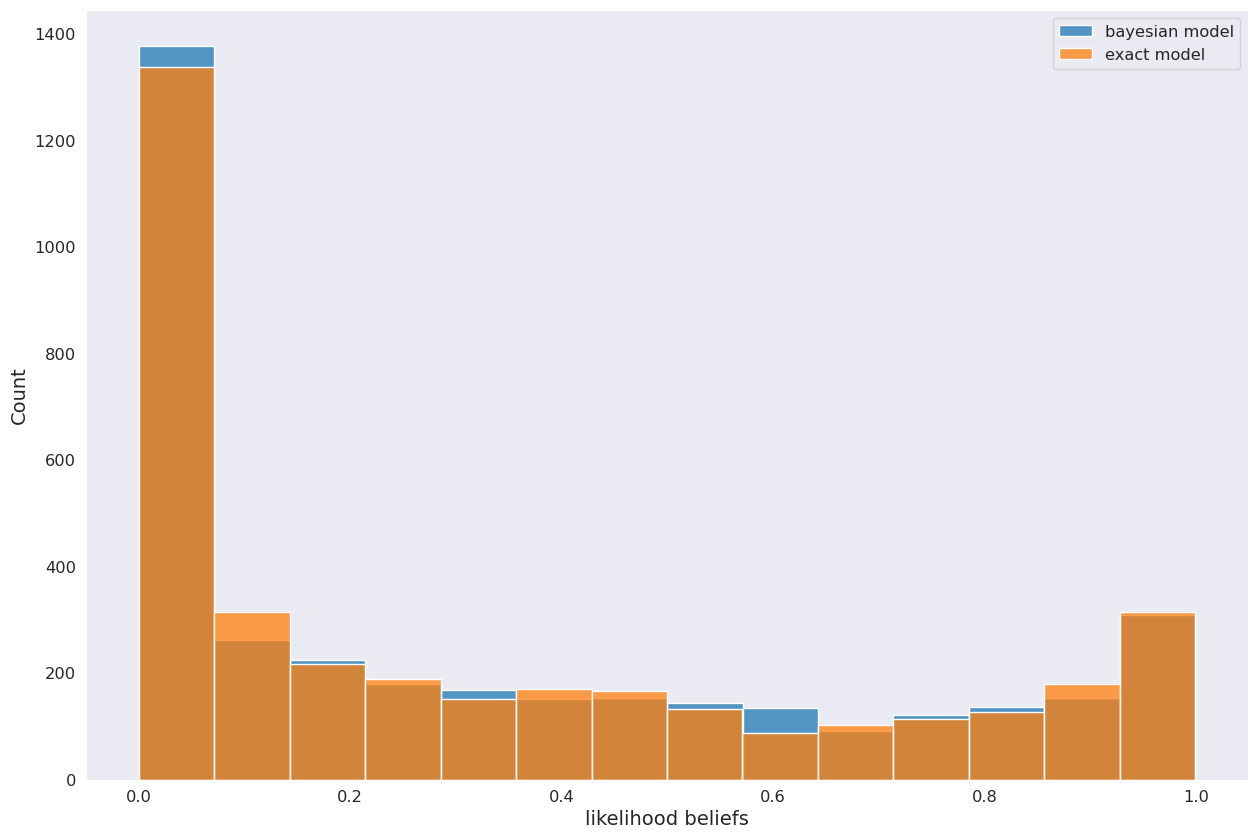

In [37]:
%matplotlib inline
fig, ax = plt.subplots()
sns.histplot(data=df_monkey, x = 'likelihood beliefs', ax = ax, label = 'bayesian model')
sns.histplot(data=df_monkey, x = 'likelihood reward probs', ax = ax, label = 'exact model')
ax.legend()

<Axes: xlabel='likelihood diffs', ylabel='Count'>

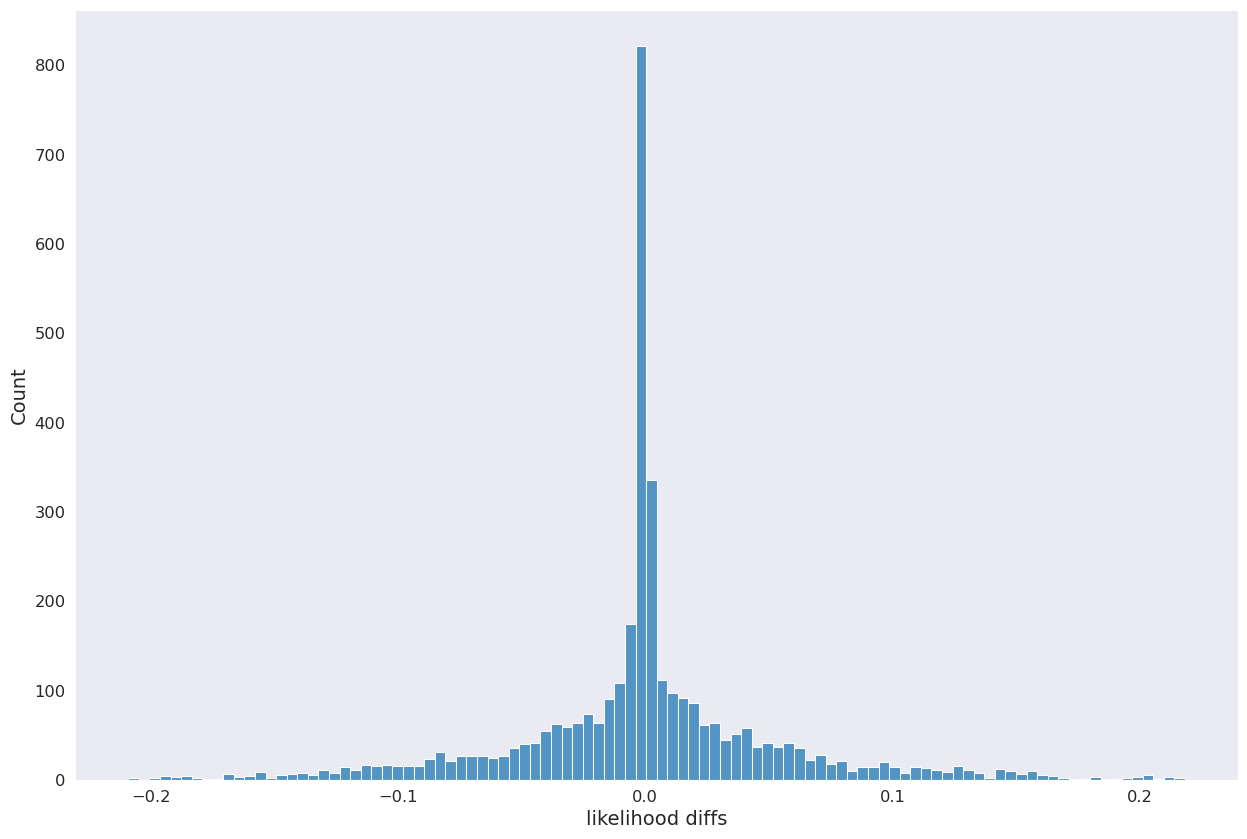

In [38]:
df_monkey['likelihood diffs'] = df_monkey['likelihood beliefs']- df_monkey['likelihood reward probs']
sns.histplot(data=df_monkey, x = 'likelihood diffs')